In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.24/06


In [2]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "20211115-8corespernode-taskset815-200x-withhld106taskset1017"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = int(timedir.split("_")[2].replace("nodes",""))
    corespernode = int(timedir.split("_")[3].replace("corespernode",""))
    chunks = nodes*corespernode
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = int(f.split("_")[1].replace("task",""))
        df["taskid"] = int(taskid)
        df["nodes"] = int(nodes)
        df["chunks"] = int(chunks)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="nodes").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes,chunks
0,54.478,27023899679,1044,28235189400,4,1,8
1,54.081,23487491005,1202,28235189400,1,1,8
2,53.311,22676183892,1245,28235189400,1,1,8
3,49.034,24453809657,1154,28235189400,1,1,8
4,52.825,27384996248,1031,28235189400,1,1,8
...,...,...,...,...,...,...,...
2011,7.767,4286149001,941,4033598448,2,7,56
2012,8.603,4406315980,915,4033598448,2,7,56
2013,8.367,4614099563,874,4033598448,2,7,56
2014,8.009,3620859897,1113,4033598448,48,7,56


In [3]:
meantaskthroughput = df.groupby(["chunks"]).mean()
meantaskthroughput = meantaskthroughput.reset_index().sort_values("chunks").reset_index(drop=True)
meantaskthroughput


,chunks,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes
0,8,52.904056,2.553424e+10,1108.652778,2.823519e+10,3.5,1.0
1,16,26.296965,1.295529e+10,1092.409722,1.411759e+10,7.5,2.0
2,24,17.780245,8.778927e+09,1075.347222,9.411730e+09,11.5,3.0
3,32,13.387747,6.429032e+09,1103.170139,7.058797e+09,15.5,4.0
4,40,10.883767,5.469805e+09,1035.933333,5.647038e+09,19.5,5.0
5,48,9.081949,4.615359e+09,1024.770833,4.705865e+09,23.5,6.0
6,56,8.147744,4.277264e+09,946.228175,4.033598e+09,27.5,7.0


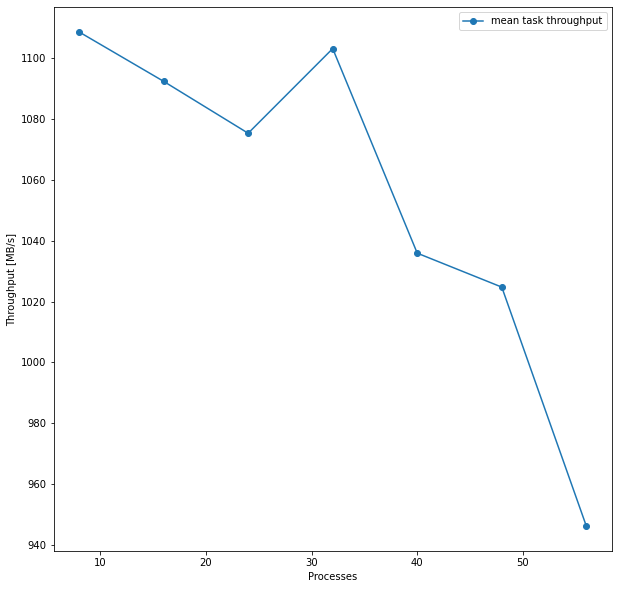

In [4]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["chunks"], meantaskthroughput["readthroughput"], label="mean task throughput", marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

In [5]:
sumthroughput = df.groupby(["chunks","nodes","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["chunks","nodes"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput["speedup"] = sumthroughput["readthroughput"] / sumthroughput["readthroughput"][0] 
sumthroughput

,chunks,nodes,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput,speedup
0,8,1,28,423.232444,2.042739e+11,8869.222222,2.258815e+11,8.661350,1.000000
1,16,2,120,420.751444,2.072846e+11,17478.555556,2.258815e+11,17.068902,1.970698
2,24,3,276,426.725889,2.106943e+11,25808.333333,2.258815e+11,25.203451,2.909876
3,32,4,496,428.407889,2.057290e+11,35301.444444,2.258815e+11,34.474067,3.980219
4,40,5,780,435.350667,2.187922e+11,41437.333333,2.258815e+11,40.466146,4.672037
5,48,6,1128,435.933556,2.215373e+11,49189.000000,2.258815e+11,48.036133,5.546033
6,56,7,1540,456.273667,2.395268e+11,52988.777778,2.258815e+11,51.746853,5.974456


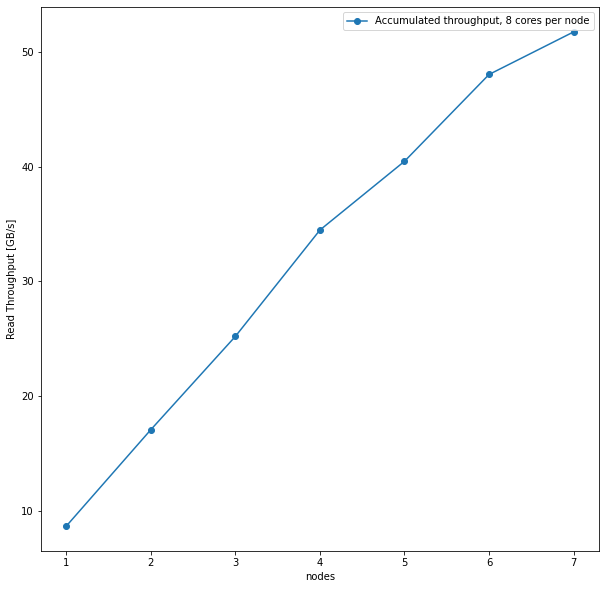

In [6]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["totalthroughput"], label="Accumulated throughput, 8 cores per node", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Read Throughput [GB/s]")
pyplot.legend()

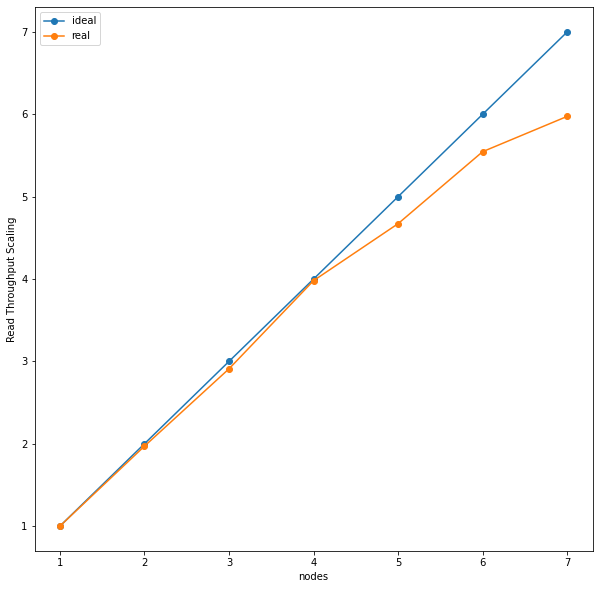

In [7]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["nodes"], label="ideal", marker="o")
pyplot.plot(sumthroughput["nodes"], sumthroughput["speedup"], label="real", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Read Throughput Scaling")
pyplot.legend()

# Python timer

In [8]:
times = {"nodes":[],"meanruntime":[], "err":[], "throughput_GB_s":[]}
timedir = "20211115-8corespernode-taskset815-200x-withhld106taskset1017/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = 225881515200 # taken from the RNTuple metrics above

for f in os.listdir(timedir):
    array = numpy.genfromtxt(os.path.join(timedir, f), skip_header=2)
    nodes = f.split("_")[5].replace("nodes","")
    time_mean = numpy.mean(array)
    times["nodes"].append(int(nodes))
    times["meanruntime"].append(round(time_mean, 2))
    times["err"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_GB_s"].append(readsize/time_mean/pow(10,9))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="nodes").reset_index(drop=True).copy()
throughput_1node = timesdf["throughput_GB_s"][0]
time_1node = timesdf["meanruntime"][0]
timesdf["runtimespeedup"] = time_1node / timesdf["meanruntime"]
timesdf["throughputspeedup"] = timesdf["throughput_GB_s"] / throughput_1node
timesdf

,nodes,meanruntime,err,throughput_GB_s,runtimespeedup,throughputspeedup
0,1,54.77,0.52,4.124259,1.000000,1.000000
1,2,27.85,0.29,8.109700,1.966607,1.966341
2,3,18.91,0.15,11.944925,2.896351,2.896260
3,4,14.75,0.14,15.311276,3.713220,3.712492
4,5,12.08,0.15,18.691838,4.533940,4.532169
5,6,10.14,0.12,22.269146,5.401381,5.399551
6,7,9.50,0.09,23.769495,5.765263,5.763338


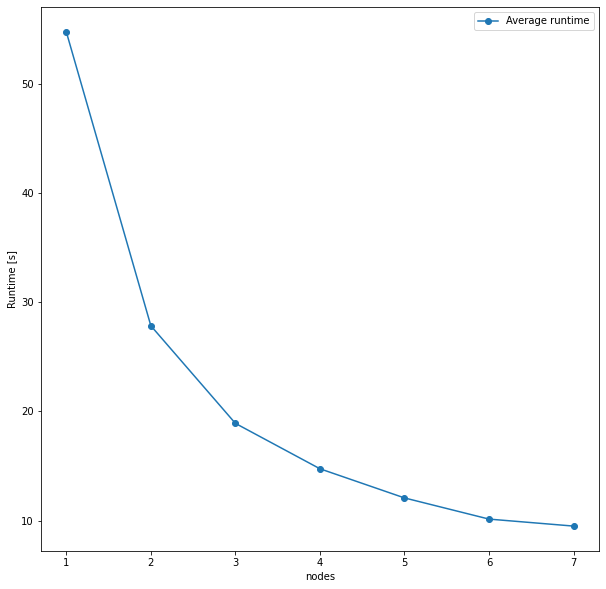

In [9]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["meanruntime"], label="Average runtime", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Runtime [s]")
pyplot.legend()

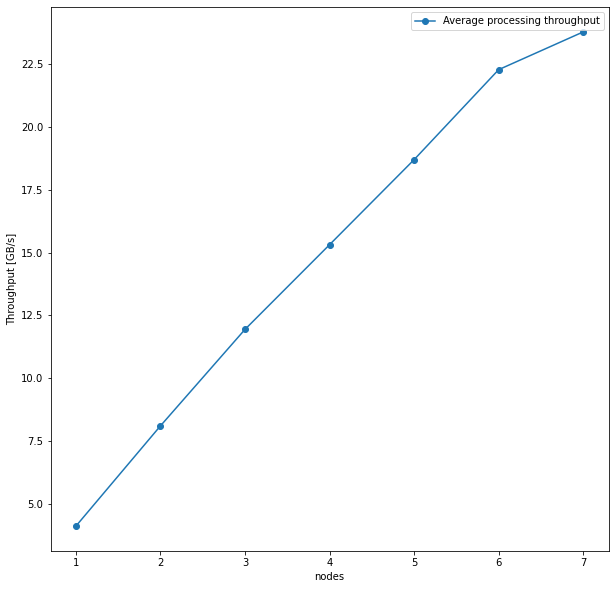

In [10]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughput_GB_s"], label="Average processing throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Throughput [GB/s]")
pyplot.legend()

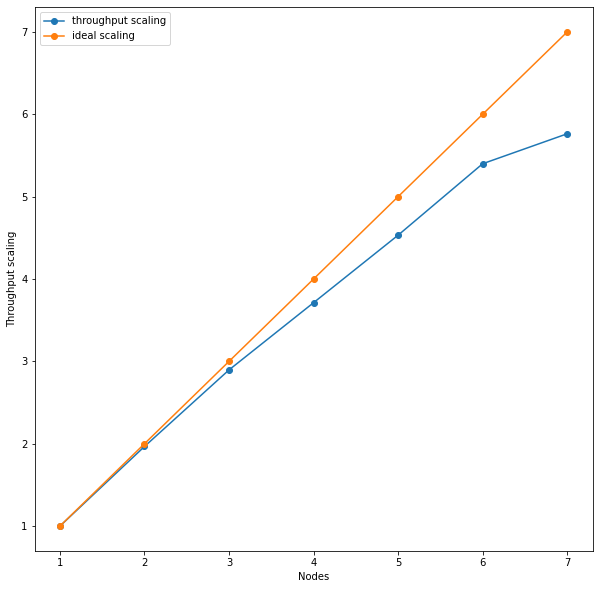

In [11]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughputspeedup"], label="throughput scaling", marker="o")
pyplot.plot(timesdf["nodes"], timesdf["nodes"], label="ideal scaling", marker="o")
pyplot.xticks(timesdf["nodes"])
pyplot.yticks(timesdf["nodes"])
pyplot.xlabel("Nodes")
pyplot.ylabel("Throughput scaling")
pyplot.legend()

# TGraph

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_processingthroughput.png has been created


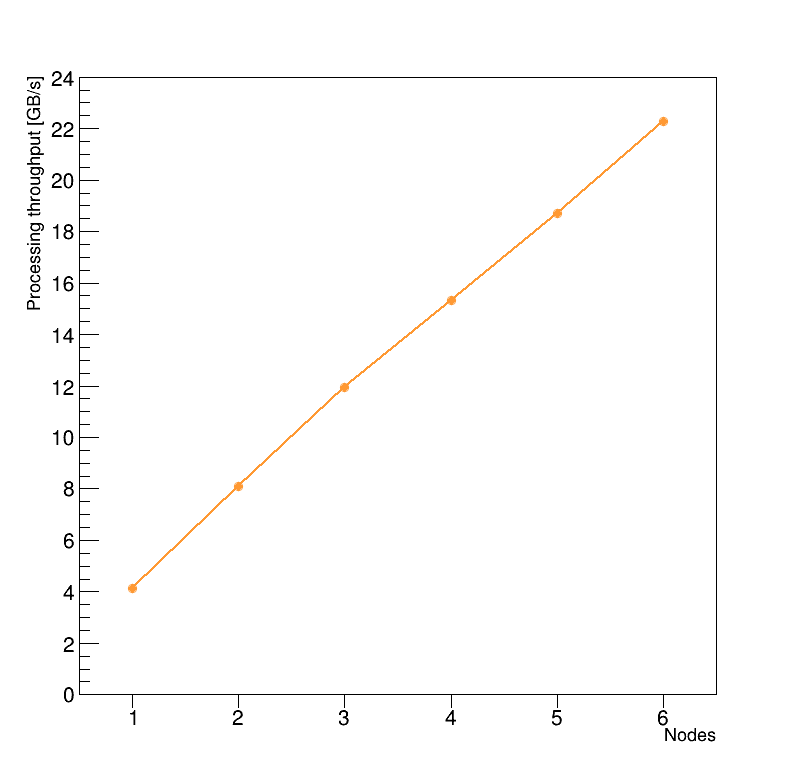

In [55]:
runtimegraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["throughput_GB_s"], dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Nodes")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Processing throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 24)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(timesdf["nodes"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_multinode_processingthroughput.png")

In [1]:
speedupgraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["nodes"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Processing throughput scaling")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
#idealspeedupgraph.GetYaxis().SetRangeUser(0, 6)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["nodes"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, 0.17, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(1)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(2)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.35,0.9)
legend.AddEntry(speedupgraph, "Real scaling")
legend.AddEntry(idealspeedupgraph, "Ideal scaling", "L")
legend.Draw()
ROOT.gStyle.SetLegendTextSize(0.025)
c.Draw()
c.SaveAs("distrdf_lhcb_multinode_processingthroughputspeedup.png")

NameError: name 'ROOT' is not defined